In [1]:
import numpy as np
from math import pow
import scipy.optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 载入原始数据

### 获取基站个数sta_num（第一行），终端个数dev_num（第二行），数据维度（第三行）

In [2]:
handle_list=[]
with open('./Dataset_2016c/sample_case001_input.txt','r') as handle:
    for line in handle:
        handle_list.append(line.strip('\n'))
sta_num = int(handle_list[0])
dev_num = int(handle_list[1])
dimension = int(handle_list[2])

### 构建基站位置列表

In [3]:
sta_list = []
for i in range(3,3+sta_num):
    sta_list.append([float(x) for x in handle_list[i].split('\t') if x != ''])

### 构建终端TOA列表

In [4]:
toa_list = []
for i in range(3+sta_num,3+sta_num+dev_num):
    toa_list.append([float(x) for x in handle_list[i].split('\t') if x != ''])

## 2 定位基本模型

### 构建矩阵A、X、Y，并用最小二乘法求解最小值
![矩阵](Dataset_2016c/tutorial_img/matrix.png)
![δ](Dataset_2016c/tutorial_img/delta_equation.png)

In [9]:
def residual(p,mat_A,K_k,L_k):
    mat_Y = []
    count = 0
    # skip k
    is_first = 1
    for i in range(sta_num):
        L_i = wave_spread_speed * toa_list[k_2][i]
        if is_valid_TOA(L_i):
            if not is_first:
                K_i = x_i*x_i+y_i*y_i+z_i*z_i
                mat_Y.append(K_i-pow(L_i*p[count+dimension],2)-K_k+pow(L_k*p[dimension],2))
                count += 1
            else:
                is_first = 0
    mat_temp = np.dot(mat_A,[p[0],p[1],p[2]])-mat_Y
    # delta = np.sum(np.multiply(mat_temp,mat_temp))
    delta = float(np.dot(mat_temp.T,mat_temp))
    return delta

def is_valid_TOA(L):
    if L <= float(200/.62):
        return True
    else:
        return False

handle_list=[]
with open('./Dataset_2016c/sample_case001_ans.txt','r') as handle:
    for line in handle:
        handle_list.append(line.strip('\n'))
ans_list = []
for line in handle_list:
    ans_list.append([float(x) for x in line.split('\t') if x != ''])

wave_spread_speed = 3e8
result_list_x = []
result_list_y = []
result_list_z = []
total_error = .0
for k_2 in range(dev_num):
    mat_A = []
    for k in range(sta_num):
        L_k = wave_spread_speed * toa_list[k_2][k]
        if is_valid_TOA(L_k):
            x_k,y_k,z_k = sta_list[k][0],sta_list[k][1],sta_list[k][2]
            K_k = x_k*x_k+y_k*y_k+z_k*z_k
            break
    if not (x_k and y_k and z_k):
        print("{:<4}:Bad signal!".format(k_2))
        continue
    for i in range(sta_num):
        L_i = wave_spread_speed * toa_list[k_2][i]
        if is_valid_TOA(L_i): # 假设每个基站的通信半径为200米，考虑到NLOS，除以折减系数（超过范围虽然有测量数据，但无效）
            x_i,y_i,z_i = sta_list[i][0],sta_list[i][1],sta_list[i][2]
            mat_A.append([x_i-x_k,y_i-y_k,z_i-z_k])
    del mat_A[0]
    if len(mat_A) < 3:
        print("{:<4}:-----------------Not enough valid TOA data! Available: {}-----------------".format(k_2,len(mat_A)))
        continue
    # 以TOA最小值对应的基站坐标为初始值
    p_init = sta_list[toa_list[k_2].index(min(toa_list[k_2]))][:]
    cons = ({'type': 'ineq', 'fun': lambda x: 40000-pow(x[0]-p_init[0],2)-pow(x[1]-p_init[1],2)-pow(x[2]-p_init[2],2)})
    bnds = [(None,None),(None,None),(None,None)]
    for i in range(len(mat_A)):
        p_init.append(.85) # φ_i
        bnds.append((0.62,0.98))
    param=scipy.optimize.minimize(residual,p_init,args=(mat_A,K_k,L_k),method='SLSQP',constraints=cons,bounds=bnds)
    param_round = np.round(param.x,2)
    print("{:<4}:[{:>7},{:>7},{:>7}]; Answer:[{:>7},{:>7},{:>7}]; Error: {}".format(k_2,param_round[0],param_round[1],param_round[2],ans_list[k_2][0],ans_list[k_2][1],ans_list[k_2][2],round(np.linalg.norm(param_round[:3]-ans_list[k_2]),2)))
    result_list_x.append(np.round(param.x,2)[0])
    result_list_y.append(np.round(param.x,2)[1])
    result_list_z.append(np.round(param.x,2)[2])
    total_error += np.linalg.norm(param_round[:3]-ans_list[k_2])
print("Total error: {}".format(total_error))

0   :[  -57.4,  -9.29,   4.52]; Answer:[ -21.19,   4.48,   1.48]; Error: 38.86
1   :[  -57.4,  -9.29,   4.52]; Answer:[ -81.14,  58.24,   1.38]; Error: 71.65
2   :[  -84.5,-184.89,   4.58]; Answer:[ -96.13,-215.22,   1.02]; Error: 32.68
3   :[-273.67, -21.14,   4.98]; Answer:[-296.06, -20.15,   1.59]; Error: 22.67
4   :[  36.29, -85.79,   3.19]; Answer:[  86.29,-111.06,   1.66]; Error: 56.04
5   :[  20.77, 244.49,   4.81]; Answer:[ -31.26, 244.68,    1.3]; Error: 52.15
6   :[-273.67, -21.14,   4.98]; Answer:[-286.47, -38.75,   1.73]; Error: 22.01
7   :[ 279.66,-128.13,   3.98]; Answer:[  319.3,-170.11,   1.03]; Error: 57.81
8   :[  20.77, 244.49,   4.81]; Answer:[  -37.4, 273.59,   1.73]; Error: 65.12
9   :[ 265.96, 107.13,   3.37]; Answer:[ 255.34,  66.63,   1.21]; Error: 41.92
10  :[  20.77, 244.49,   4.81]; Answer:[ 104.46, 203.54,   1.95]; Error: 93.22
11  :[  -57.4,  -9.29,   4.52]; Answer:[-120.39,  92.32,   1.72]; Error: 119.58
12  :[  20.77, 244.49,   4.81]; Answer:[ 114.52, 19

152 :[ 166.94,  -6.84,    3.4]; Answer:[ 174.04,  29.67,    1.4]; Error: 37.25
153 :[  -57.4,  -9.29,   4.52]; Answer:[ -84.09,  61.57,   1.68]; Error: 75.77
154 :[ 219.81, 176.67,   5.12]; Answer:[ 185.66, 138.52,   1.68]; Error: 51.32
155 :[-200.11, -24.32,   5.32]; Answer:[-180.38,  36.99,    1.3]; Error: 64.53
156 :[  -57.4,  -9.29,   4.52]; Answer:[-111.45,   6.05,    1.2]; Error: 56.28
157 :[ 166.94,  -6.84,    3.4]; Answer:[  222.2, -17.97,   1.47]; Error: 56.4
158 :[  87.23,  -13.2,   3.86]; Answer:[  61.77, -26.65,   1.32]; Error: 28.91
159 :[  -5.79, 153.43,    4.2]; Answer:[-139.89, 195.34,   1.74]; Error: 140.52
160 :-----------------Not enough valid TOA data! Available: 2-----------------
161 :[-317.88, 114.67,   5.07]; Answer:[-270.45, 189.63,   1.52]; Error: 88.78
162 :[  -84.5,-184.89,   4.58]; Answer:[ -132.1,-157.72,   1.73]; Error: 54.88
163 :[  20.77, 244.49,   4.81]; Answer:[ -61.57,  308.7,    1.7]; Error: 104.46
164 :[ 219.81, 176.67,   5.12]; Answer:[ 220.09, 16

291 :[  -57.4,  -9.29,   4.52]; Answer:[ -59.87, -18.88,   1.99]; Error: 10.22
292 :-----------------Not enough valid TOA data! Available: 1-----------------
293 :[-222.06, 318.47,   2.12]; Answer:[-103.34, 321.52,   1.82]; Error: 118.76
294 :-----------------Not enough valid TOA data! Available: 1-----------------
295 :[-317.88, 114.67,   5.07]; Answer:[-263.79, 164.66,   1.67]; Error: 73.73
296 :[ 303.74, -10.07,   3.26]; Answer:[ 288.59,   0.01,   1.25]; Error: 18.31
297 :[  36.29, -85.79,   3.19]; Answer:[ 131.65,-100.55,   1.47]; Error: 96.51
298 :[  36.29, -85.79,   3.19]; Answer:[  47.47, -93.36,   1.82]; Error: 13.57
299 :-----------------Not enough valid TOA data! Available: 2-----------------
300 :[  24.85,  90.74,   2.22]; Answer:[  36.53,  54.58,   1.71]; Error: 38.0
301 :[   9.76, -28.57,   2.24]; Answer:[ -16.08, -27.03,   1.31]; Error: 25.9
302 :[ 166.94,  -6.84,    3.4]; Answer:[ 202.15, -45.82,   1.24]; Error: 52.57
303 :[  78.37,  96.95,   3.15]; Answer:[ 117.87,  56.

453 :[  -57.4,  -9.29,   4.52]; Answer:[  -56.0,  -5.44,   1.99]; Error: 4.81
454 :[ 166.94,  -6.84,    3.4]; Answer:[ 204.21,  45.49,   1.09]; Error: 64.29
455 :[  36.29, -85.79,   3.19]; Answer:[ 108.19, -99.19,    1.2]; Error: 73.17
456 :[-273.67, -21.14,   4.98]; Answer:[-318.73,  35.94,   1.19]; Error: 72.82
457 :[  -84.5,-184.89,   4.58]; Answer:[ -95.64,-158.72,   1.38]; Error: 28.62
458 :[-268.62,-100.39,   4.84]; Answer:[-297.24,-112.22,   1.83]; Error: 31.11
459 :[-273.67, -21.14,   4.98]; Answer:[-317.73,  38.59,   1.63]; Error: 74.3
460 :[  -3.92,-273.36,   5.47]; Answer:[ 103.09,-280.07,   1.99]; Error: 107.28
461 :[-268.62,-100.39,   4.84]; Answer:[-324.53, -147.8,   1.66]; Error: 73.37
462 :[-317.88, 114.67,   5.07]; Answer:[-216.66, 103.01,   1.78]; Error: 101.94
463 :[ 252.85, 260.85,   3.29]; Answer:[ 166.89, 272.97,   1.37]; Error: 86.83
464 :[  -5.79, 153.43,    4.2]; Answer:[ -127.7, 120.88,   1.46]; Error: 126.21
465 :[  20.77, 244.49,   4.81]; Answer:[ -17.79, 24

603 :[ 303.74, -10.07,   3.26]; Answer:[ 261.05, -16.16,   1.47]; Error: 43.16
604 :[  -84.5,-184.89,   4.58]; Answer:[-102.63,-278.45,   1.47]; Error: 95.35
605 :[  273.4, 227.51,   5.09]; Answer:[ 296.93,  230.6,   1.12]; Error: 24.06
606 :[ 166.94,  -6.84,    3.4]; Answer:[ 232.19, -55.25,   1.16]; Error: 81.28
607 :[-178.93, -51.22,   2.26]; Answer:[-163.01, -64.35,   1.37]; Error: 20.66
608 :[-200.11, -24.32,   5.32]; Answer:[-195.52,  56.59,   1.98]; Error: 81.11
609 :[  20.77, 244.49,   4.81]; Answer:[ 111.42, 219.37,   1.28]; Error: 94.13
610 :[ 257.91,-212.53,   2.66]; Answer:[ 216.63,-213.43,   1.05]; Error: 41.32
611 :[-317.88, 114.67,   5.07]; Answer:[-312.34, 123.06,   1.16]; Error: 10.79
612 :[ 265.96, 107.13,   3.37]; Answer:[ 301.16,  78.38,   1.27]; Error: 45.5
613 :[  -3.92,-273.36,   5.47]; Answer:[  92.97,-280.31,   1.48]; Error: 97.22
614 :[ 279.66,-128.13,   3.98]; Answer:[  196.4,-135.23,    1.8]; Error: 83.59
615 :[ 252.85, 260.85,   3.29]; Answer:[ 198.09, 266.

752 :[-268.62,-100.39,   4.84]; Answer:[-241.98, -66.48,   1.49]; Error: 43.25
753 :-----------------Not enough valid TOA data! Available: 1-----------------
754 :[-268.62,-100.39,   4.84]; Answer:[-280.86,-142.77,   1.87]; Error: 44.21
755 :[-170.69,-193.88,    4.7]; Answer:[ 223.01,  19.85,   1.24]; Error: 447.99
756 :[-273.67, -21.14,   4.98]; Answer:[-282.66,  42.17,   1.36]; Error: 64.05
757 :[ 166.94,  -6.84,    3.4]; Answer:[  163.6,  10.65,   1.65]; Error: 17.89
758 :[ 166.94,  -6.84,    3.4]; Answer:[ 141.88,-112.08,   1.22]; Error: 108.2
759 :-----------------Not enough valid TOA data! Available: 1-----------------
760 :-----------------Not enough valid TOA data! Available: 2-----------------
761 :[ 252.85, 260.85,   3.29]; Answer:[ 249.01, 315.34,   1.72]; Error: 54.65
762 :[  78.37,  96.95,   3.15]; Answer:[ 107.92, 116.21,   1.02]; Error: 35.34
763 :[-222.06, 318.47,   2.12]; Answer:[ -130.7, 235.71,    1.9]; Error: 123.27
764 :[-268.62,-100.39,   4.84]; Answer:[ -296.3,-1

905 :[ 252.85, 260.85,   3.29]; Answer:[ 219.36, 229.18,   1.41]; Error: 46.13
906 :[  36.29, -85.79,   3.19]; Answer:[  27.97, -80.81,   1.46]; Error: 9.85
907 :[-273.67, -21.14,   4.98]; Answer:[-239.71, -24.34,   1.01]; Error: 34.34
908 :[  273.4, 227.51,   5.09]; Answer:[ 297.94, 226.62,   1.49]; Error: 24.82
909 :[ 166.94,  -6.84,    3.4]; Answer:[ 164.66,    9.3,   1.97]; Error: 16.36
910 :[-194.46,-119.81,   5.41]; Answer:[-207.77,-199.49,   1.85]; Error: 80.86
911 :[  -5.79, 153.43,    4.2]; Answer:[-113.31, 166.48,   1.51]; Error: 108.34
912 :-----------------Not enough valid TOA data! Available: 2-----------------
913 :[ 166.94,  -6.84,    3.4]; Answer:[ 166.65,  39.97,   1.95]; Error: 46.83
914 :-----------------Not enough valid TOA data! Available: 1-----------------
915 :[  36.29, -85.79,   3.19]; Answer:[ 104.55, -87.35,   1.04]; Error: 68.31
916 :-----------------Not enough valid TOA data! Available: 1-----------------
917 :[-273.67, -21.14,   4.98]; Answer:[-300.24, -35

1069:[  273.4, 227.51,   5.09]; Answer:[  310.2, 219.15,   1.28]; Error: 37.93
1070:[ 219.81, 176.67,   5.12]; Answer:[ 169.89, 225.45,   1.14]; Error: 69.91
1071:[  20.77, 244.49,   4.81]; Answer:[  -9.66, 286.38,   1.84]; Error: 51.86
1072:[  -5.79, 153.43,    4.2]; Answer:[ -35.66, 178.73,   1.69]; Error: 39.23
1073:[  -3.92,-273.36,   5.47]; Answer:[  12.93,-220.02,   1.59]; Error: 56.07
1074:-----------------Not enough valid TOA data! Available: 2-----------------
1075:[ -32.55,-110.14,   2.77]; Answer:[ -72.76,-128.09,   1.92]; Error: 44.04
1076:[  -5.79, 153.43,    4.2]; Answer:[ -70.99,  86.14,   1.35]; Error: 93.74
1077:[ 252.85, 260.85,   3.29]; Answer:[ 185.17, 288.57,   1.07]; Error: 73.17
1078:[  24.85,  90.74,   2.22]; Answer:[  18.31, 111.17,   1.57]; Error: 21.46
1079:[ 257.91,-212.53,   2.66]; Answer:[ 193.56,-239.01,   1.97]; Error: 69.59
1080:[  -84.5,-184.89,   4.58]; Answer:[-111.45,-222.48,   1.35]; Error: 46.37
1081:[  36.29, -85.79,   3.19]; Answer:[  29.21, -61

### 可视化

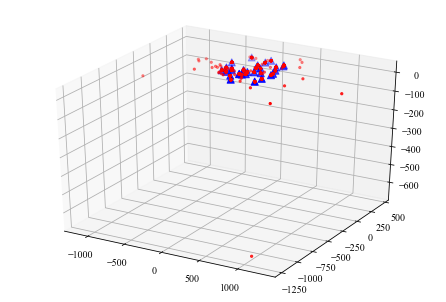

In [6]:
plt.rc('font',family='Times New Roman')
plt.rc('pdf', fonttype=42)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(result_list_x,result_list_y,result_list_z,c='r',s=5)
ax.scatter(np.array(sta_list)[:,0],np.array(sta_list)[:,1],np.array(sta_list)[:,2],c='blue',marker="^", s=50)
plt.savefig("Dataset_2016c/3d_scatter_plot.pdf")
plt.show()